In [2]:
import os
import sys
import gc

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

In [3]:
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from src.utils import fix_seed, save_config, save_compiled_config

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator

import numpy as np

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.data import MyDataset, load_data, transform_data
from src.training.train import Trainer
from src.utils import fix_seed, save_config, save_compiled_config

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# plot parameters
standard_size: int = 14

plt.rc('font', size=standard_size)          # controls default text sizes
plt.rc('axes', titlesize=standard_size)     # fontsize of the axes title
plt.rc('axes', labelsize=standard_size)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=standard_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=standard_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=standard_size)    # legend fontsize
plt.rc('figure', titlesize=standard_size)   # fontsize of the figure title

In [6]:
# colors
colors = ["#003f5c","#58508d","#bc5090","#ff6361","#ffa600"]
l_colors = ["#00205e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#00cc80"]

np.random.seed(5)

def get_color(index: int, palette: str = 'short'):
    """
    Get a HEX color from a defined palette
    :param: index (int)
    :param: palette (str) "short" (5 colors), "long" (9 colors), "" (black)
    """
    if palette == 'short':
        m = len(colors)
        return colors[(4 * index) % m]
    if palette == 'long':
        n = len(l_colors)
        return l_colors[(7 * index) % n]
    return "#000"

# Functions

In [7]:
def train(cfg, train_loader, test_loader):
    augmentator = (
        [instantiate(trans) for trans in cfg["transform_data"]] if cfg["transform_data"]
        else None
    )
    
    logger = SummaryWriter(cfg["save_path"] + "/tensorboard")
    fix_seed(cfg['model_id_attack'])

    const_params = {
        "logger": logger,
        "print_every": 10, #cfg["print_every"],
        "device": device,
        "seed": cfg['model_id_attack'],
        "train_self_supervised": False
    }

    trainer_params = dict(cfg["training_params"])
    trainer_params.update(const_params)
    trainer = Trainer.initialize_with_params(**trainer_params)

    trainer.train_model(train_loader, test_loader)
    logger.close()
    
    return trainer.model


def get_attacks(cfg, eps, n_steps_list, model):
    attack_model = model

    criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])
    
    disc_check_list = None
    
    estimator = AttackEstimator(
        disc_check_list,
        cfg["metric_effect"],
        cfg["metric_hid"],
        batch_size=cfg["estimator_batch_size"],
    )
    
    attacks = list()
    
    for n_steps in n_steps_list:
        attack_params = dict(cfg["attack"]["attack_params"])
        attack_params["model"] = attack_model
        attack_params["criterion"] = criterion
        attack_params["estimator"] = estimator
        attack_params["alpha"] = 0
        attack_params["eps"] = eps
        attack_params["n_steps"] = n_steps
    
        attacks.append(get_attack(cfg["attack"]["name"], attack_params))

    return attacks

# Config + data

In [8]:
initialize(config_path='config/my_configs', version_base=None)
cfg = compose(config_name='mix_exp.yaml')

In [9]:
print("Dataset", cfg["dataset"]['name'])

X_train, y_train, X_test, y_test = load_data(cfg["dataset"]['name'])

X_train, X_test, y_train, y_test = transform_data(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    slice_data=cfg["slice"]
)

test_loader = DataLoader(
    MyDataset(X_test, y_test), 
    batch_size=cfg["batch_size"], 
    shuffle=False
)

train_loader = DataLoader(
    MyDataset(X_train, y_train), 
    batch_size=cfg["batch_size"], 
    shuffle=False
)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Dataset FordA


# Train original model

In [10]:
model_orig = train(cfg, train_loader, test_loader)

Epoch 1 train loss: 0.662; acc_train 0.588; test loss: 0.587; acc_test 0.701; f1_test 0.678; balance 0.444; certainty 0.628
Epoch 11 train loss: 0.069; acc_train 0.984; test loss: 0.396; acc_test 0.848; f1_test 0.847; balance 0.514; certainty 0.911
Epoch 21 train loss: 0.005; acc_train 1.0; test loss: 0.529; acc_test 0.85; f1_test 0.847; balance 0.499; certainty 0.943
Epoch 31 train loss: 0.001; acc_train 1.0; test loss: 0.582; acc_test 0.85; f1_test 0.847; balance 0.499; certainty 0.951
Epoch 41 train loss: 0.001; acc_train 1.0; test loss: 0.619; acc_test 0.848; f1_test 0.844; balance 0.494; certainty 0.956
Epoch 51 train loss: 0.0; acc_train 1.0; test loss: 0.636; acc_test 0.846; f1_test 0.843; balance 0.494; certainty 0.957


### Attack data with original data

In [133]:
n_steps_list = np.arange(5, 25, 5) ##### менять

attacks = get_attacks(cfg, 0.05, n_steps_list, model_orig)

logging
logging
logging
logging


In [134]:
attacked_train = {}

for attack in attacks:
    X_adv = attack.apply_attack(train_loader).squeeze()
    attacked_train[attack.n_steps] = X_adv

100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


In [136]:
first_batchX, first_batchY = next(iter(train_loader))

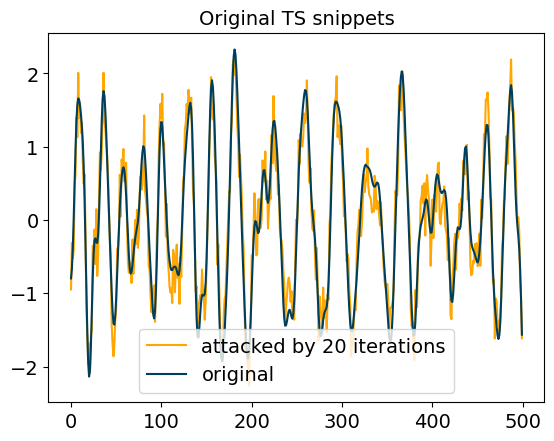

In [143]:
plt.title('Original TS snippets')
plt.plot(attacked_train[20][0], c=get_color(1), label='attacked by 20 iterations')
plt.plot(first_batchX[0], c=get_color(0), label='original')
plt.legend()

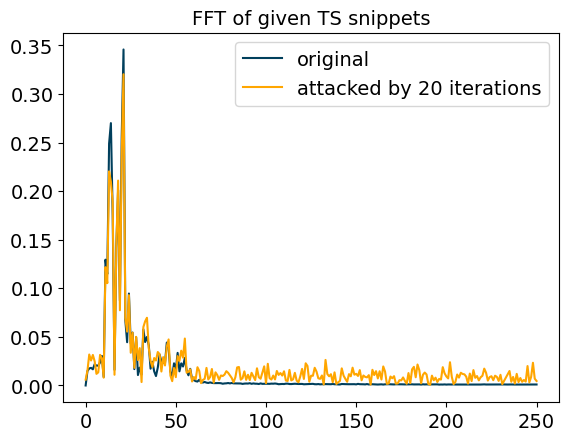

In [150]:
plt.title('FFT of given TS snippets')
plt.plot(abs(rfft(first_batchX[0].numpy().reshape(1, -1)[0])) / 500, color=get_color(0), label='original')
plt.plot(abs(rfft(attacked_train[15][0].numpy())) / 500, color=get_color(1), label='attacked by 20 iterations')
plt.legend()

In [144]:
preds_orig = model_orig(first_batchX.to(device)).detach().cpu().numpy()
preds_orig[np.where(preds_orig > 0.5)] = 1
preds_orig[np.where(preds_orig < 0.5)] = 0

preds_attacked20 = model_orig(attacked_train[20].unsqueeze(-1)[:cfg['batch_size']].to(device)).detach().cpu().numpy()
preds_attacked20[np.where(preds_attacked20 > 0.5)] = 1
preds_attacked20[np.where(preds_attacked20 < 0.5)] = 0

In [145]:
torch.cuda.empty_cache()
gc.collect()

121

In [146]:
accuracy_score(preds_orig, first_batchY)

1.0

In [147]:
accuracy_score(first_batchY, preds_attacked20)

0.0625

In [153]:
attacked_train_plotter = {}

n_steps_list = np.arange(1, 26, 1) ##### менять

attacks = get_attacks(cfg, 0.05, n_steps_list, model_orig)

for attack in attacks:
    X_adv = attack.apply_attack(train_loader).squeeze()
    attacked_train_plotter[attack.n_steps] = X_adv[5]

logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging


100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


Text(300, 2, '12 iteration')

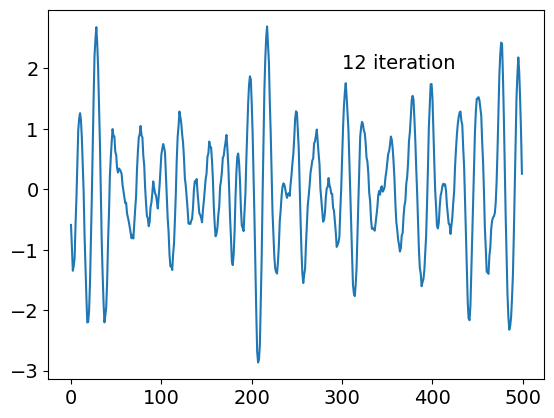

In [160]:
plt.plot(attacked_train_plotter[1])#[1][0]
plt.text(300, 2, f'{12}' + ' iteration')

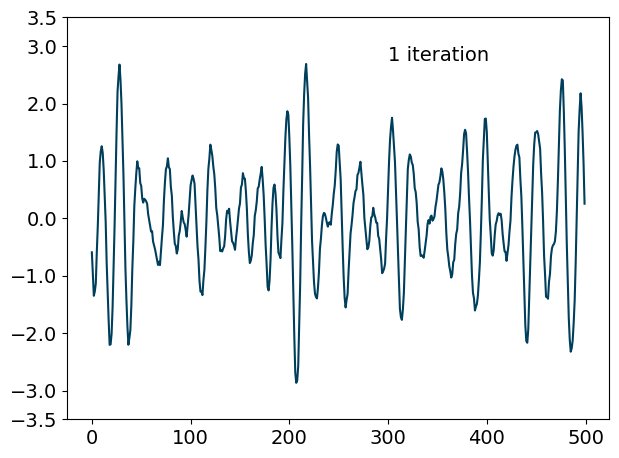

In [172]:
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.rcParams.update({'font.size' : 20})

fig, ax = plt.subplots()
#div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')
plt.tight_layout()
ax.set_title('Adversarial attacked sample')

def animate(t):
    ax.clear()
    ax.plot(attacked_train_plotter[t + 1], c=get_color(0))#[1][0]
    ax.text(300, 2.75, f'{t + 1}' + ' iteration')
    ax.set_yticks([-3.5, -3.0, -2, -1, 0, 1, 2, 3, 3.5])

    return fig, ax

ani = animation.FuncAnimation(fig, animate, frames=25, interval=200)
ani.save('AdvTrain.gif', fps=15

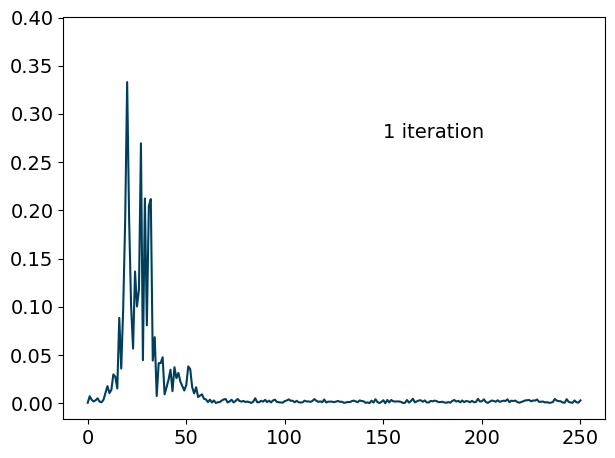

In [182]:
fig, ax = plt.subplots()
#div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')
plt.tight_layout()
ax.set_title('Adversarial attacked sample')

def animate(t):
    ax.clear()
    plt.plot(abs(rfft(attacked_train_plotter[t + 1].numpy())) / 500, color=get_color(0))
    ax.text(150, 0.275, f'{t + 1}' + ' iteration')
    
    ax.set_yticks(np.arange(0, 0.41, 0.05))

    return fig, ax

ani = animation.FuncAnimation(fig, animate, frames=25, interval=200)
ani.save('AdvFourier.gif', fps=15)

### Mix attack data with train

In [10]:
X_train = train_loader.dataset.X
y_train = train_loader.dataset.y

X_train_mixed = torch.cat([X_train, attacked_train[5]]) ###### шаги атаки
y_train_mixed = torch.cat([y_train, y_train])

train_loader_mixed = DataLoader(
    MyDataset(X_train_mixed, y_train_mixed), 
    batch_size=cfg["batch_size"], 
    shuffle=True
)

# Train on mixed

In [11]:
model_mixed = train(cfg, train_loader_mixed, test_loader)

Epoch 1 train loss: 0.401; acc_train 0.836; test loss: 0.303; acc_test 0.911; f1_test 0.918; balance 0.589; certainty 0.774
Epoch 11 train loss: 0.078; acc_train 0.981; test loss: 0.122; acc_test 0.967; f1_test 0.968; balance 0.533; certainty 0.91
Epoch 21 train loss: 0.035; acc_train 1.0; test loss: 0.078; acc_test 0.978; f1_test 0.978; balance 0.522; certainty 0.946
Epoch 31 train loss: 0.013; acc_train 1.0; test loss: 0.056; acc_test 0.989; f1_test 0.989; balance 0.511; certainty 0.964
Epoch 41 train loss: 0.006; acc_train 1.0; test loss: 0.052; acc_test 0.989; f1_test 0.989; balance 0.511; certainty 0.97
Epoch 51 train loss: 0.004; acc_train 1.0; test loss: 0.05; acc_test 0.989; f1_test 0.989; balance 0.511; certainty 0.974


# Test

In [8]:
attacks = get_attacks(cfg, 0.05, n_steps_list, model_mixed) # Атакуем градиентами новой модели
# attacks = get_attacks(cfg, 0.05, n_steps_list, model_orig) # Атакуем градиентами оригинальной модели

X_test = test_loader.dataset.X
y_test = test_loader.dataset.y

attacked_test = {}

for attack in attacks:
    X_adv = attack.apply_attack(test_loader).squeeze()
    attacked_test[attack.n_steps] = X_adv

NameError: name 'n_steps_list' is not defined

# Comparison

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
criterion = torch.nn.BCELoss()

test_samples = attacked_test[20].unsqueeze(-1).to(device) ###### шаги атаки

preds_orig = model_orig(test_samples) 
preds_mixed = model_mixed(test_samples)

In [ ]:
print(
    criterion(preds_orig, y_test.float().to(device)).item(),
    criterion(preds_mixed, y_test.float().to(device)).item()
)

In [ ]:
roc_auc_score(y_test, preds_orig.cpu().detach().numpy()) # 0.06807

In [ ]:
roc_auc_score(y_test, preds_mixed.cpu().detach().numpy()) # 0.1283

# PCA

In [77]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

from plotly.express import scatter

In [95]:
X_test_mixed = torch.cat([X_test, attacked_test[5]]) ###### шаги атаки
labels = model_orig(X_test_mixed.unsqueeze(-1).to(device))

types = torch.cat([torch.zeros_like(y_test), torch.ones_like(y_test)])

In [96]:
modify = TSNE(2, perplexity=20)

In [97]:
new_data = modify.fit_transform(X_test_mixed)

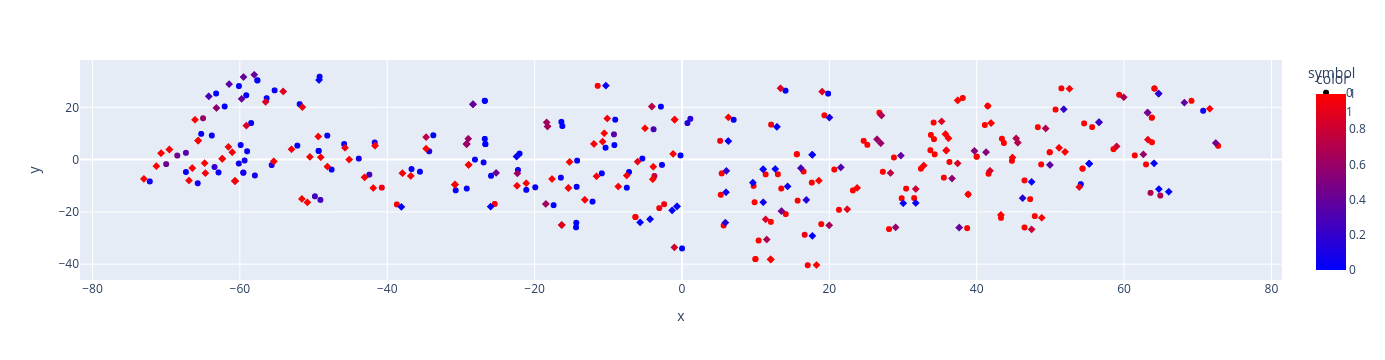

In [98]:
scatter(
    x = new_data[:, 0],
    y = new_data[:, 1],
    # z = new_data[:, 2],
    size_max = 10,
    color = labels.detach().squeeze().cpu().numpy(),
    color_continuous_scale = 'bluered',
    symbol = types.squeeze()
)

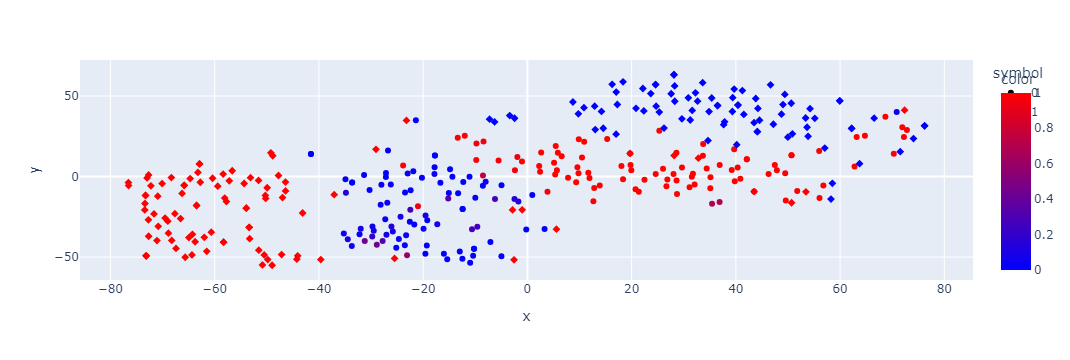

In [94]:
scatter(
    x = new_data[:, 0],
    y = new_data[:, 1],
    # z = new_data[:, 2],
    size_max = 10,
    color = labels.detach().squeeze().cpu().numpy(),
    color_continuous_scale = 'bluered',
    symbol = types.squeeze()
)